In [ ]:
%cd /content/drive/My Drive/NN_INTRO_HW

/content/drive/My Drive/NN_INTRO_HW


In [ ]:
!pip install pandas scikit-learn gensim matplotlib

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report

In [ ]:
quora = pd.read_csv('quora.csv')

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)


273056

In [ ]:

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

14083

In [ ]:
# индексируем слова
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:

id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

In [ ]:
MAX_LEN

134

In [ ]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape

(1306122, 134)

In [ ]:
y = quora.target.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
mean = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=10)

Epoch 1/10
2424/2424 [==============================] - 91s 38ms/step - loss: 0.1503 - accuracy: 0.9460 - val_loss: 0.1196 - val_accuracy: 0.9527
Epoch 2/10
2424/2424 [==============================] - 90s 37ms/step - loss: 0.1152 - accuracy: 0.9538 - val_loss: 0.1136 - val_accuracy: 0.9553
Epoch 3/10
2424/2424 [==============================] - 91s 37ms/step - loss: 0.1093 - accuracy: 0.9557 - val_loss: 0.1120 - val_accuracy: 0.9563
Epoch 4/10
2424/2424 [==============================] - 91s 37ms/step - loss: 0.1059 - accuracy: 0.9569 - val_loss: 0.1121 - val_accuracy: 0.9561
Epoch 5/10
2424/2424 [==============================] - 91s 38ms/step - loss: 0.1031 - accuracy: 0.9579 - val_loss: 0.1129 - val_accuracy: 0.9560
Epoch 6/10
2424/2424 [==============================] - 91s 38ms/step - loss: 0.1001 - accuracy: 0.9590 - val_loss: 0.1151 - val_accuracy: 0.9543
Epoch 7/10
2424/2424 [==============================] - 91s 38ms/step - loss: 0.0968 - accuracy: 0.9603 - val_loss: 0.1168 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


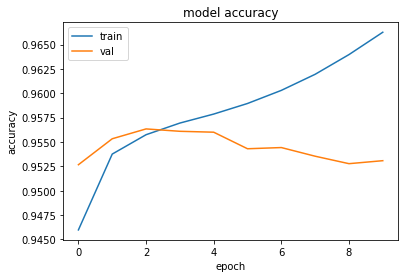

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
def make_model(emb_type, dense_layers, activation, batch_size, epochs, verbose=1):
  inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
  embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
  if emb_type == 'mean':
    new_embs = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
  elif emb_type == 'sum':
    new_embs = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
  else:
    new_embs = tf.keras.layers.Flatten()(embeddings)
    
  dense = dense_layers[0](new_embs)
  for i in range(1, len(dense_layers)):
    dense = dense_layers[i](dense)
  outputs = tf.keras.layers.Dense(1, activation=activation)(dense)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  model.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose)
 

  print(model.history.history.keys())
  # summarize history for accuracy
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  preds = model.predict(X_valid).reshape(-1)
  print(classification_report(y_valid, (preds > 0.5).astype(int)))



In [ ]:
activations = ['relu',
               'softmax',
               'sigmoid',
               'exponential',
               'linear']

## Сначала попробуем конкатенацию

activation - relu
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


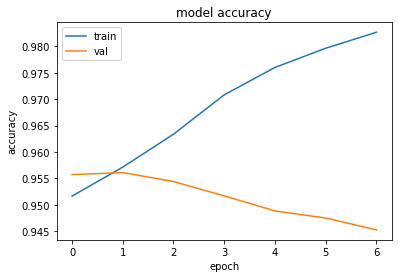

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     61367
           1       0.55      0.52      0.53      3940

    accuracy                           0.95     65307
   macro avg       0.76      0.75      0.75     65307
weighted avg       0.94      0.95      0.94     65307

activation - softmax
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


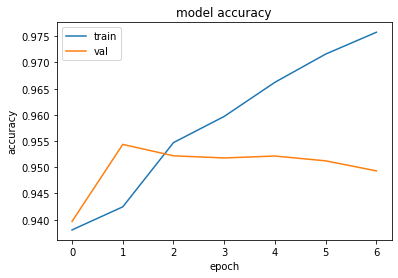

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     61367
           1       0.59      0.52      0.55      3940

    accuracy                           0.95     65307
   macro avg       0.78      0.75      0.76     65307
weighted avg       0.95      0.95      0.95     65307

activation - sigmoid
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


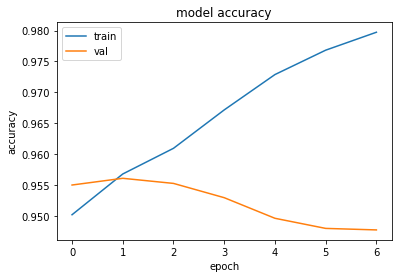

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     61367
           1       0.58      0.50      0.53      3940

    accuracy                           0.95     65307
   macro avg       0.77      0.74      0.75     65307
weighted avg       0.94      0.95      0.95     65307

activation - exponential
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


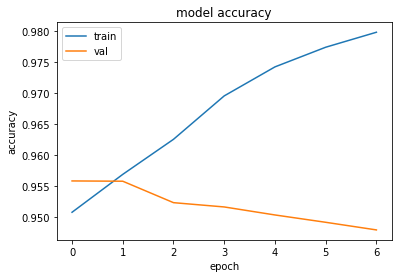

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     61367
           1       0.59      0.46      0.51      3940

    accuracy                           0.95     65307
   macro avg       0.78      0.72      0.74     65307
weighted avg       0.94      0.95      0.94     65307

activation - linear
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


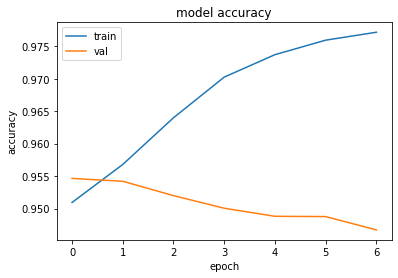

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     61367
           1       0.57      0.46      0.51      3940

    accuracy                           0.95     65307
   macro avg       0.77      0.72      0.74     65307
weighted avg       0.94      0.95      0.94     65307



In [ ]:
batch_size = 512
epochs = 7
for activation in activations:
  print("activation - %s" %activation)
  make_model("con", [tf.keras.layers.Dense(50, activation=activation)], "sigmoid", batch_size, epochs, 0)

Лучший результат macro F1 = 0.76 

## Cложение эмбеддингов 

activation - relu
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


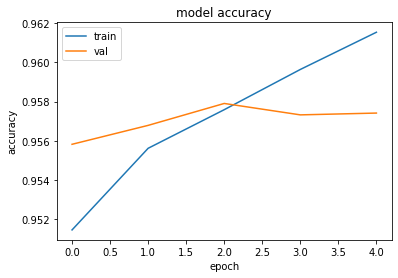

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61367
           1       0.68      0.56      0.61      3940

    accuracy                           0.96     65307
   macro avg       0.83      0.77      0.79     65307
weighted avg       0.95      0.96      0.96     65307

activation - softmax
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


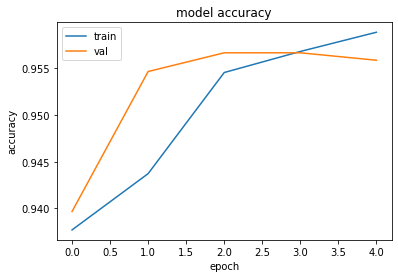

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     61367
           1       0.71      0.46      0.56      3940

    accuracy                           0.96     65307
   macro avg       0.84      0.72      0.77     65307
weighted avg       0.95      0.96      0.95     65307

activation - sigmoid
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


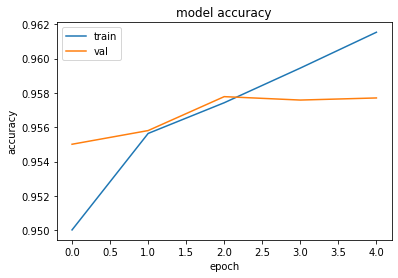

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61367
           1       0.68      0.56      0.61      3940

    accuracy                           0.96     65307
   macro avg       0.83      0.77      0.80     65307
weighted avg       0.95      0.96      0.96     65307

activation - exponential
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


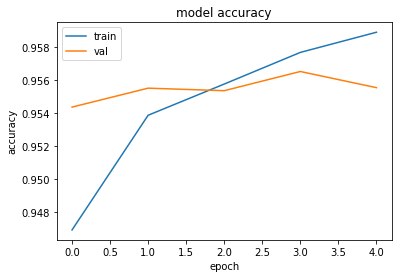

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     61367
           1       0.72      0.43      0.54      3940

    accuracy                           0.96     65307
   macro avg       0.84      0.71      0.76     65307
weighted avg       0.95      0.96      0.95     65307

activation - linear
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


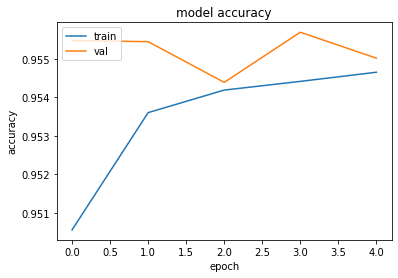

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61367
           1       0.65      0.55      0.60      3940

    accuracy                           0.96     65307
   macro avg       0.81      0.77      0.79     65307
weighted avg       0.95      0.96      0.95     65307



In [ ]:
epochs = 5
for activation in activations:
  print("activation - %s" %activation)
  make_model("sum", [tf.keras.layers.Dense(50, activation=activation)], "sigmoid", batch_size, epochs, 0)

Лучший результат macro F1 = 0.80

## Усреднение

In [ ]:
import gensim
dim = 200
texts = quora.question_text.apply(preprocess).tolist()

In [ ]:
ft = gensim.models.FastText(texts, size=dim, iter=2, window=3)

In [ ]:
w2v = gensim.models.Word2Vec(texts, size=dim, window=3, min_count=1)

In [ ]:
def get_weights(word2id, model):

  dim = model.vector_size
  weights = np.zeros((len(word2id), dim))

  for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights[i] = model.wv.get_vector("adopted") 
    try:
        weights[i] = model.wv.get_vector(word)
    except KeyError:
      weights[i] = model.wv.get_vector("adopted") 
  return weights

In [ ]:
weights_ft = get_weights(word2id, ft)
weights_w2v = get_weights(word2id, w2v)

Epoch 1/5
249/249 [==============================] - 91s 364ms/step - loss: 0.1626 - accuracy: 0.9385 - val_loss: 0.1383 - val_accuracy: 0.9448
Epoch 2/5
249/249 [==============================] - 91s 365ms/step - loss: 0.1343 - accuracy: 0.9469 - val_loss: 0.1346 - val_accuracy: 0.9472
Epoch 3/5
249/249 [==============================] - 91s 366ms/step - loss: 0.1299 - accuracy: 0.9485 - val_loss: 0.1339 - val_accuracy: 0.9464
Epoch 4/5
249/249 [==============================] - 91s 364ms/step - loss: 0.1261 - accuracy: 0.9500 - val_loss: 0.1331 - val_accuracy: 0.9482
Epoch 5/5
249/249 [==============================] - 91s 366ms/step - loss: 0.1228 - accuracy: 0.9515 - val_loss: 0.1319 - val_accuracy: 0.9492
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


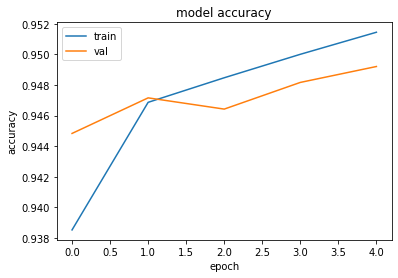

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     61221
           1       0.66      0.38      0.49      4086

    accuracy                           0.95     65307
   macro avg       0.81      0.69      0.73     65307
weighted avg       0.94      0.95      0.94     65307



In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings_ft = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, trainable=False, weights=[weights_ft])(inputs)
embeddings_w2v = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, trainable=False, weights=[weights_w2v])(inputs)
conc_emb = tf.keras.layers.Concatenate()([embeddings_ft, embeddings_w2v])

transformed = tf.keras.layers.Flatten()(conc_emb)
  
dense = tf.keras.layers.Dense(100, activation="relu")(transformed)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
          epochs=5,
          verbose=1)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds = model.predict(X_valid).reshape(-1)
print(classification_report(y_valid, (preds > 0.5).astype(int)))

По метрикам мы видим, что сложение сработало лучше всего